# Generate nNPS data #

The purpose of this notebook is to create a dummy dataset for modelling network NPS. Essentially, this code serves as a customer network simulation. What we would like to do is to mimic interactions between customers and sites, and the nework performance for such interactions. This can be graphically represented by a bipartite graph having a set of nodes for sites $S_N$ and a set of nodes for customers $C_K$. To generate the dataset we follow these steps: 

1. for each site sample a daily site performance KPI $x_N$ (from a mixture distribution),
2. for each site sample a number of daily connections $D_N$ (from a degree distribution),
3. for each number of connections in $D_N$ sample a random customer id from $C_K$ (from a uniform distribution),
4. for each customer calculate p(*hadBadInteraction*) using a deterministic OR.
5. for each customer add a noise factor to determine p(*isDetractor*):
    1. a *binary symmetric channel* (BSC) model to create false positives,
    2. a BSC model to create false negatives.

In [1]:
3

3

In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib.tri as tri
import matplotlib as mpl
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from sklearn.metrics import classification_report
from scipy.stats import multivariate_normal
# plt.style.use(['science','ieee'])

In [3]:
# unique sites unique customers ratio: 1724 / 15680 = 0.10

num_days = 5
num_sites = 10
N = num_days*num_sites # number of daily sites (i.e., days*sites)

true_mean_0 = -70
true_mean_1 = -120

true_precision_0 = 0.05
true_precision_1 = 0.05

def sample(component):
    if component == 0:
        return np.random.normal(true_mean_0, np.sqrt(1 / true_precision_0), 1)[0]
    if component == 1:
        return np.random.normal(true_mean_1, np.sqrt(1 / true_precision_1), 1)[0]

# comp 0 = good, comp 1 = bad
mask = np.random.choice([0, 1], N, p=[0.9, 0.1])
kpi_data = [sample(i) for i in mask]
df_kpi = pd.DataFrame(kpi_data, columns=['x'])
df_kpi['comp'] = mask
df_kpi.shape

(50, 2)

In [ ]:
mean_vector = [0,1]
std_vector = [1,1]

def sampe


In [40]:
df_kpi

,x,comp
0,-67.458796,0
1,-117.199313,1
2,-76.546939,0
3,-74.259734,0
4,-62.426171,0
5,-59.172449,0
6,-72.053945,0
7,-69.124872,0
8,-72.183592,0
9,-116.961380,1


In [4]:
1/0.05

20.0

For each site, sample a daily degree.

In [5]:
# Note: this is the daily site degree distribution.
D = np.random.poisson(5, N)
D.shape

(50,)

In [6]:
# plt.hist(D, 100, alpha=0.4, color='gray')
# plt.grid()
# plt.xlabel('Degree distribution')
# plt.title('Daily site degree distribution')
# plt.show()

We have N number of daily sites for which each daily site needs to be uniformly allocated to customers.

In [7]:
num_customers = 20
customer_ids = list(range(num_customers))
daily_site_ids = list(range(N))
cust_site_dict = {}

for i in daily_site_ids:
    num_customer_connections = D[i]
    np.random.shuffle(customer_ids)
    ids = customer_ids[:num_customer_connections]
    for j in ids:
        if j in cust_site_dict:
            temp_list = cust_site_dict[j]
            temp_list.append(i)
            cust_site_dict.update({j:temp_list})
        else:
            cust_site_dict.update({j:[i]})        

In [8]:
# test uniqueness
# for k, v in cust_site_dict.items():
#     if len(v) != len(set(v)):
#         print(k)

In [9]:
df_temp = pd.DataFrame.from_dict(cust_site_dict, orient='index')

In [10]:
df_temp.sort_index(inplace=True)

In [11]:
kpis = []
comp = []
hadBadInteraction = []

for index, row in df_temp.iterrows():
    x = row.values
    ids = x[~np.isnan(x)].astype(int)
    kpis.append(df_kpi.loc[ids, 'x'].values.round(2).tolist())
    comp.append(df_kpi.loc[ids, 'comp'].values)
    hadBadInteraction.append(np.any(df_kpi.loc[ids, 'comp']))

In [12]:
# y = list(map(lambda x: 1 if x else 0, hadBadInteraction))
# plt.hist(y, 10)
# plt.grid()
# plt.xlabel('$p(hadBadInteraction)$')
# plt.show()

In [13]:
df_temp['kpis'] = kpis
df_temp['component'] = comp
df_temp['hadBadInteraction'] = hadBadInteraction

In [14]:
df_customers = df_temp.loc[:, :'kpis'].drop(['kpis'], axis=1)

In [15]:
df_customers = df_customers.apply(lambda x: list(x[~np.isnan(x)].astype(int)), axis=1)

In [16]:
df_customers = pd.DataFrame(df_customers, columns=['temp'])

In [17]:
df_customers['site_ids'] = [','.join(map(str, l)) for l in df_customers['temp']]

Create dataset.csv file, which has number of customers as rows and jagged daily site ids as columns.

In [18]:

df_customers['site_ids'].to_csv('dataset-generate.csv', sep=',', header=False, index=False)

Create kpis.csv file, which has number of days multiplied with number of unique sites equal to the number of rows.

In [19]:
df_kpi['x'].to_csv('kpis-generate.csv', sep=',', header=False, index=False)

Create responses.csv file, which has number of customers as rows.

In [20]:
# need to apply some noisy rule here!!!
df_customers['hadBadInteraction'] = df_temp['hadBadInteraction'].astype(int)
df_customers['isDetractor'] = df_customers['hadBadInteraction']

# hadBadSiteInt, isDetractor, p(isDetractor|hadBadSiteInt)
# 0              0            0.8
# 0              1            0.2 (Bernoulli(0.2)) - 20% of all 0 hadBadSiteInt's should be flipped
# 1              0            0.2
# 1              1            0.8 (Bernoulli(0.8)) - 20% of all 1 hadBadSiteInt's should be flipped

mask = df_customers[df_customers['hadBadInteraction'] == 0].sample(frac=0.2).index.values
df_customers.loc[mask, 'isDetractor'] = 1
mask = df_customers[df_customers['hadBadInteraction'] == 1].sample(frac=0.2).index.values
df_customers.loc[mask, 'isDetractor'] = 0

In [21]:
df_customers['isDetractor'].to_csv('responses-generate.csv', sep=',', header=False, index=False)

Some stats:

In [22]:
df_kpi['comp'].value_counts() / df_kpi.shape[0]

0    0.86
1    0.14
Name: comp, dtype: float64

In [23]:
df_customers['isDetractor'].value_counts() / df_customers.shape[0]

1    0.7
0    0.3
Name: isDetractor, dtype: float64

Testing the Infer.NET model outputs:

In [24]:
customer_file = "/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/customer-results.csv"
site_file = "/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/sites-results.csv"
gmm_file = "/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/gmm-results.csv"
kpi_file = "/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/dataset-10-11-2020/lte-kpis.csv"
weights_file = "/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/weights-results.csv"

df_customers_results = pd.read_csv(customer_file, header=None, names=['hadBadSiteInter', 'FP', 'TP'])
df_sites_results = pd.read_csv(site_file, header=None, names=['hadBadPerf'])
df_gmm_results = pd.read_csv(gmm_file, header=None, names=['mean0',
                                                           'mean1',
                                                           'var0',
                                                           'var1',
                                                           'var2',
                                                           'var3'])
df_kpi_data = pd.read_csv(kpi_file, header=None, names=['avg_SIGNAL_POWER_dBm', 'avg_SIGNAL_QUALITY_dB'], sep=';')
df_weights_results = pd.read_csv(weights_file, header=None, names=['weights'], sep=',')

df_customers_results.shape, df_sites_results.shape, df_gmm_results.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/v000045832/Documents/nnps-infer/nnps-infer/bin/Debug/netcoreapp3.1/customer-results.csv'

In [ ]:
# def correlation_from_covariance(covariance):
#     v = np.sqrt(np.diag(covariance))
#     outer_v = np.outer(v, v)
#     correlation = covariance / outer_v
#     correlation[covariance == 0] = 0
#     return correlation

In [ ]:
# df_customers['hadBadSiteInterPred'] = df_customers_results['hadBadSiteInter'].round(3)

In [ ]:
# df_kpi['hadBadPerf'] = df_sites_results['hadBadPerf']

In [ ]:
# y_true = df_kpi['comp']
# y_pred = np.where(df_kpi['hadBadPerf'] > 0.5, 1, 0)
# target_names = ['promotors', 'detractors']
# print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# fpr, tpr, _ = roc_curve(df_kpi['comp'], df_kpi['hadBadPerf'])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], color='black', linestyle='--')
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.05])
# plt.title("AUC: {0:.3f}".format(roc_auc))
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid()
# plt.show()

In [ ]:
df_kpi_data['p(badSite)'] = df_sites_results['hadBadPerf']

In [ ]:
df_kpi_data = df_kpi_data[df_kpi_data < 100000].astype(float)

In [ ]:
# df_kpi_data = df_kpi_data[~df_kpi_data.isnull()]

In [ ]:
df_kpi_data = df_kpi_data.dropna()

In [ ]:
# plt.scatter(df_kpi_data['avg_SIGNAL_POWER_dBm'],
#             df_kpi_data['avg_SIGNAL_QUALITY_dB'],
#             alpha=0.5,
#             marker='.',
#             c=df_kpi_data['p(badSite)'],
#             cmap=cm.coolwarm)
# plt.show()

In [ ]:
# df_gmm_results

In [ ]:
mean0 = df_gmm_results.loc[0, ['mean0','mean1']].values
mean1 = df_gmm_results.loc[1, ['mean0','mean1']].values
prec0 = df_gmm_results.loc[0, ['var0','var1', 'var2', 'var3']].values.reshape(2, 2)
prec1 = df_gmm_results.loc[1, ['var0','var1', 'var2', 'var3']].values.reshape(2, 2)

# g0 = multivariate_normal(mean0, prec0)
# g1 = multivariate_normal(mean1, prec1)

KeyError: 0.0

In [ ]:
# correlation_from_covariance(prec0)

In [ ]:
# correlation_from_covariance(prec1)

In [25]:
# df_kpi_data['lhg0'] = np.log(g0.pdf(df_kpi_data.loc[:, ['avg_SIGNAL_POWER_dBm', 'avg_SIGNAL_QUALITY_dB']]))
# df_kpi_data['lhg1'] = np.log(g1.pdf(df_kpi_data.loc[:, ['avg_SIGNAL_POWER_dBm', 'avg_SIGNAL_QUALITY_dB']]))

In [26]:
# def exp_normalize(row):
#     b = row.max()
#     y = np.exp(row - b)
#     return (y / y.sum())[1]

In [27]:
# df_kpi_data['p(badSite)'] = df_kpi_data[['lhg0', 'lhg1']].apply(exp_normalize, axis=1)

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
x0_min = df_kpi_data['avg_SIGNAL_POWER_dBm'].min()
x0_max = df_kpi_data['avg_SIGNAL_POWER_dBm'].max()
x1_min = df_kpi_data['avg_SIGNAL_QUALITY_dB'].min()
x1_max = df_kpi_data['avg_SIGNAL_QUALITY_dB'].max()

x, y = np.mgrid[x0_min:x0_max:0.1, x1_min:x1_max:0.1]

pos = np.dstack((x, y))

ax.scatter(df_kpi_data['avg_SIGNAL_POWER_dBm'],
           df_kpi_data['avg_SIGNAL_QUALITY_dB'],
           marker='.',
           label='KPI data',
           color='gray',
           alpha=0.01)

for index, row in df_gmm_results.iterrows():
    mean = np.array([row['mean0'], row['mean1']])
    prec = np.array([[row['var0'], row['var1']], 
                     [row['var2'], row['var3']]])
    rv = multivariate_normal(mean, prec)
    if index == 0:
        ax.contour(x, y, rv.pdf(pos), cmap='GnBu')
    else:
        ax.contour(x, y, rv.pdf(pos), cmap='OrRd')
plt.grid()

red_patch = mpatches.Patch(color='#f56a40', label='Bad class')
blue_patch = mpatches.Patch(color='#65b4e6', label='Good class')
gray_patch = mpatches.Patch(color='gray', label='Data')
plt.legend(handles=[red_patch, blue_patch, gray_patch])

plt.title("Gaussian mixture distributions")
plt.xlabel("avg SIGNAL POWER (dBm)")
plt.ylabel("avg SIGNAL QUALITY (dB)")
plt.show()  

<IPython.core.display.Javascript object>

NameError: name 'df_kpi_data' is not defined

<IPython.core.display.Javascript object>


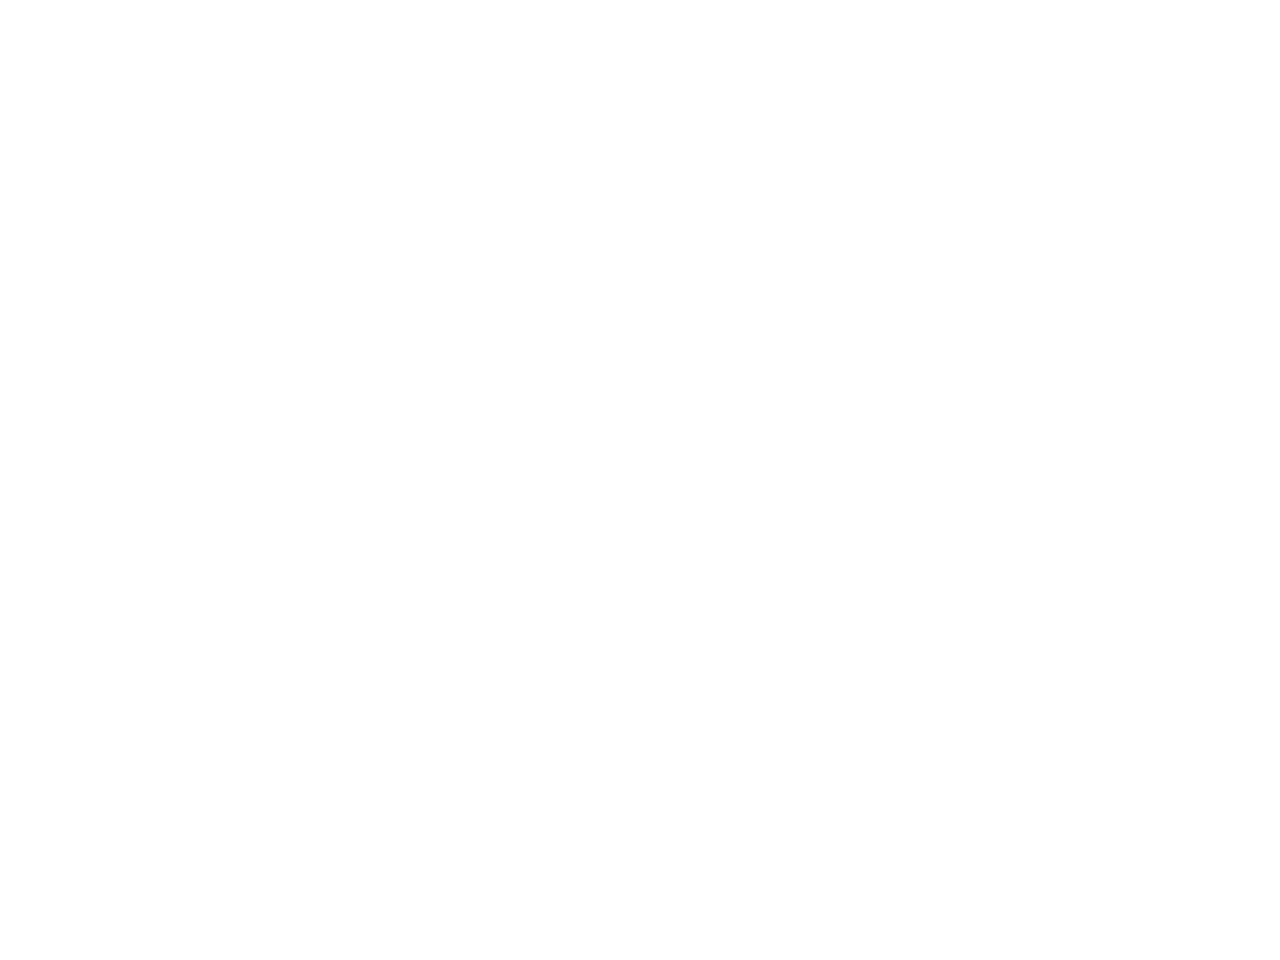

KeyError: 'kpi'

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].hist(df_kpi_data['kpi'], 100, alpha=0.4, color='gray', label='$x_{kpi}$')
ax[0].grid()
ax[0].legend()

m0 = df_gmm_results.loc[0, 'mean']
p0 = df_gmm_results.loc[0, 'precision']

sigma = np.sqrt(1 / p0)
xx = np.linspace(m0 - 6 * sigma, m0 + 6 * sigma, 500)
ax[1].plot(xx, stats.norm.pdf(xx, m0, sigma), label='Good', color='green')

m1 = df_gmm_results.loc[1, 'mean']
p1 = df_gmm_results.loc[1, 'precision']

sigma = np.sqrt(1 / p1)
xx = np.linspace(m1 - 6 * sigma, m1 + 6 * sigma, 500)
ax[1].plot(xx, stats.norm.pdf(xx, m1, sigma), label='Bad', color='red')
ax[1].grid()

w = 0.59
w0 = 1 - w
w1 = w
xx = np.linspace(-140, 40, 500)
ax[1].plot(xx, (w0 * stats.norm.pdf(xx, m0, np.sqrt(1 / p0))) + \
               (w1 * stats.norm.pdf(xx, m1, np.sqrt(1 / p1))), linestyle='--', color='black', alpha=0.3, label=r'$\sum_{k} \pi_k \mathcal{N}$($\mu_k$, $\gamma_{k}^{-1}$)')

ax[1].legend()

plt.show()

In [29]:
path = '/Users/dtoitf/InferNet/nps/bayes-point-machine/bin/Debug/net6.0/'

In [30]:
site_file = path + "sites-results.csv"
gmm_file = path + "gmm-results.csv"
kpi_file = path + "19-01-2021-datasets/dataset-kpis.csv"
weights_file = path + "weights-results.csv"

df_sites_results = pd.read_csv(site_file, header=None, names=['hadBadPerf'])
# df_gmm_results = pd.read_csv(gmm_file, header=None, names=['mean0',
#                                                            'mean1',
#                                                            'var0',
#                                                            'var1',
#                                                            'var2',
#                                                            'var3'])
df_gmm_results = pd.read_csv(gmm_file, header=None, names=['mean0',
                                                           'mean1',
                                                           'mean2',
                                                           'mean3',
                                                           'var0',
                                                           'var1',
                                                           'var2',
                                                           'var3',
                                                           'var4',
                                                           'var5',
                                                           'var6',
                                                           'var7',
                                                           'var8',
                                                           'var9',
                                                           'var10',
                                                           'var11',
                                                           'var12',
                                                           'var13',
                                                           'var14',
                                                           'var15'])
df_kpi_data = pd.read_csv(kpi_file, header=None, names=['avg_SIGNAL_POWER_dBm_lte',
                                                        'avg_SIGNAL_QUALITY_dB_lte',
                                                        'avg_SIGNAL_POWER_dBm_3g',
                                                        'avg_SIGNAL_QUALITY_dB_3g'], sep=';')
df_weights_results = pd.read_csv(weights_file, header=None, names=['weights'], sep=',')

df_sites_results.shape, df_gmm_results.shape, df_kpi_data.shape, df_weights_results.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dtoitf/InferNet/nps/bayes-point-machine/bin/Debug/net6.0/sites-results.csv'

In [ ]:
df_gmm_results

,mean0,mean1,mean2,mean3,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15
0,-88.790812,-8.813910,-100.625978,-11.880994,56.340475,11.870340,19.696961,3.057427,11.870340,5.651201,3.982484,2.100412,19.696961,3.982484,42.310750,8.516628,3.057427,2.100412,8.516628,6.949921
1,-93.103476,-8.955914,-104.698452,-13.131958,7.966624,0.614397,3.049948,-0.483655,0.614397,0.656634,0.189580,0.272285,3.049948,0.189580,5.548147,-0.243902,-0.483655,0.272285,-0.243902,0.735923


In [ ]:
df_weights_results

,weights
0,0.065927


In [ ]:
df_sites_results.min(), df_sites_results.max()

(hadBadPerf    7.445922e-162
 dtype: float64,
 hadBadPerf    0.854282
 dtype: float64)

In [ ]:
(df_sites_results['hadBadPerf'] > 0.5).sum() / df_sites_results.shape[0]

0.08021418572989972

In [ ]:
data = df_sites_results['hadBadPerf'].values.reshape(242, 1724)

In [31]:
# plt.imshow(data[:,400:600].T,
#            vmin=0,
#            vmax=1,
#            cmap='bwr')
# plt.show()

In [32]:
np.arange(242)[::10]

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240])

In [33]:
# df_sites_results.values.reshape(242, 1724)
fig, ax = plt.subplots(1, 1, figsize=(6,3))
im = ax.imshow(df_sites_results.values.reshape(242,1724)[:,400:550].T,
          norm=mpl.colors.Normalize(vmin=0, vmax=1),
          cmap='bwr')
ax.set_xticks(np.arange(242)[::20])
# ax.set_yticks(np.arange(len(columns)))
ax.set_xticklabels([i for i in np.arange(242)[::20]], fontsize=7)
# ax.set_yticklabels(columns, fontsize=7)
ax.set_xlabel("Days")
ax.set_ylabel("Site ID")

cbar = plt.colorbar(im)
fig.tight_layout()
cbar.set_label(r"$P(B_{s,i})$")
plt.savefig("days-sites.png")
plt.savefig("days-sites.pdf")
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'df_sites_results' is not defined

In [ ]:
df_weights_results

,weights
0,0.06697


In [ ]:
good_var = df_gmm_results.loc[0,'var0':'var15'].values.reshape(4, 4)
bad_var = df_gmm_results.loc[1,'var0':'var15'].values.reshape(4, 4)
# good_var = df_gmm_results.loc[0,'var0':'var3'].values.reshape(2, 2)
# bad_var = df_gmm_results.loc[1,'var0':'var3'].values.reshape(2, 2)

In [ ]:
np.sqrt(np.diag(good_var))

array([7.50620401, 2.36041992, 6.50701014, 2.62924064])

In [34]:
np.sqrt(np.diag(bad_var))

NameError: name 'bad_var' is not defined

<IPython.core.display.Javascript object>


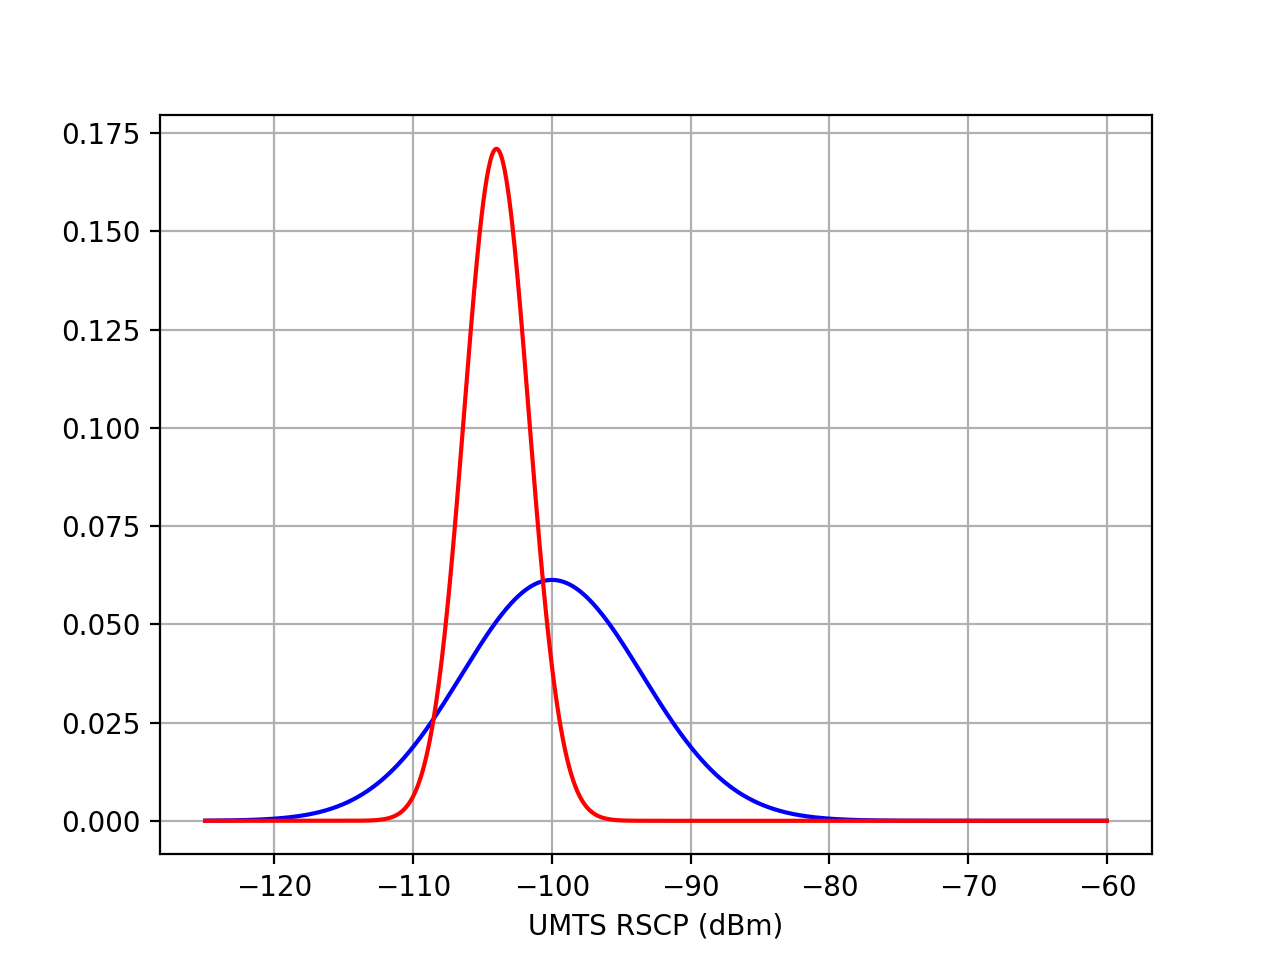

In [ ]:
xx = np.linspace(-125, -60, 1000)
plt.plot(xx, stats.norm.pdf(xx, loc=-100, scale=np.sqrt(42.34)), color='blue')
plt.plot(xx, stats.norm.pdf(xx, loc=-104, scale=np.sqrt(5.44)), color='red')
plt.xlabel("UMTS RSCP (dBm)")
plt.grid()
plt.show()

In [35]:
# RSRP
# RSRQ
# LTE will probably be more than 3G due to higher frequency
df_gmm_results

NameError: name 'df_gmm_results' is not defined

In [ ]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [36]:
good_corr = correlation_from_covariance(good_var)
bad_corr = correlation_from_covariance(bad_var)

NameError: name 'correlation_from_covariance' is not defined

In [ ]:
# columns=['avg_SIGNAL_POWER_dBm_lte', 'avg_SIGNAL_QUALITY_dB_lte']
columns=['UMTS RSCP (dBm)',
         'UMTS EC/IO (dB)',
         'LTE RSRP (dBm)',
         'LTE RSRQ (dB)',]

In [37]:
# plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

mat_good = good_corr
mat_bad = bad_corr
mask = (np.tril(mat_bad) != 0)

fig, ax = plt.subplots(1, 2, figsize=(8,5))
ax[0].spines['top'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['right'].set_visible(False)

im = ax[0].imshow(np.tril(mat_good), cmap='bwr', norm=mpl.colors.Normalize(vmin=-1, vmax=1))

ax[0].set_xticks(np.arange(len(columns)))
ax[0].set_yticks(np.arange(len(columns)))
ax[0].set_xticklabels(columns, fontsize=7)
ax[0].set_yticklabels(columns, fontsize=7)

plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(columns)):
    for j in range(len(columns)):
        if mask[i,j]:
            text = ax[0].text(j, i, mat_good[i, j].round(2),
                           ha="center", va="center", color="k")

ax[0].set_title("Promoter quality of experience\n cluster")

im = ax[1].imshow(np.tril(mat_bad), cmap='bwr', norm=mpl.colors.Normalize(vmin=-1, vmax=1))

ax[1].set_xticks(np.arange(len(columns)))
ax[1].set_yticks(np.arange(len(columns)))
ax[1].set_xticklabels(columns, fontsize=7)
ax[1].set_yticklabels([], fontsize=7)

plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(columns)):
    for j in range(len(columns)):
        if mask[i,j]:
            text = ax[1].text(j, i, mat_bad[i, j].round(2),
                           ha="center", va="center", color="k")

ax[1].set_title("Detractor quality of experience\n cluster")


fig.tight_layout()
plt.savefig('cluster-correlation.pdf')
plt.savefig('cluster-correlation.png')
plt.show()

NameError: name 'good_corr' is not defined

In [ ]:
# df_good_corr = pd.DataFrame(good_corr, columns=['avg_SIGNAL_POWER_dBm_lte',
#                                                 'avg_SIGNAL_QUALITY_dB_lte',
#                                                 'avg_SIGNAL_POWER_dBm_3g',
#                                                 'avg_SIGNAL_QUALITY_dB_3g'])
# print(df_gmm_results.loc[0,'mean0':'mean3'])
# df_good_corr.style.background_gradient(cmap='coolwarm')

In [38]:
# df_bad_corr = pd.DataFrame(bad_corr, columns=['avg_SIGNAL_POWER_dBm_lte',
#                                               'avg_SIGNAL_QUALITY_dB_lte',
#                                               'avg_SIGNAL_POWER_dBm_3g',
#                                               'avg_SIGNAL_QUALITY_dB_3g'])
# print(df_gmm_results.loc[1,'mean0':'mean3'])
# df_bad_corr.style.background_gradient(cmap='coolwarm')

In [39]:
#4g moet kleiner wees
df_kpi_data = df_kpi_data[~(df_kpi_data == 100000).any(1)]
df_kpi_data.describe()

NameError: name 'df_kpi_data' is not defined

<IPython.core.display.Javascript object>


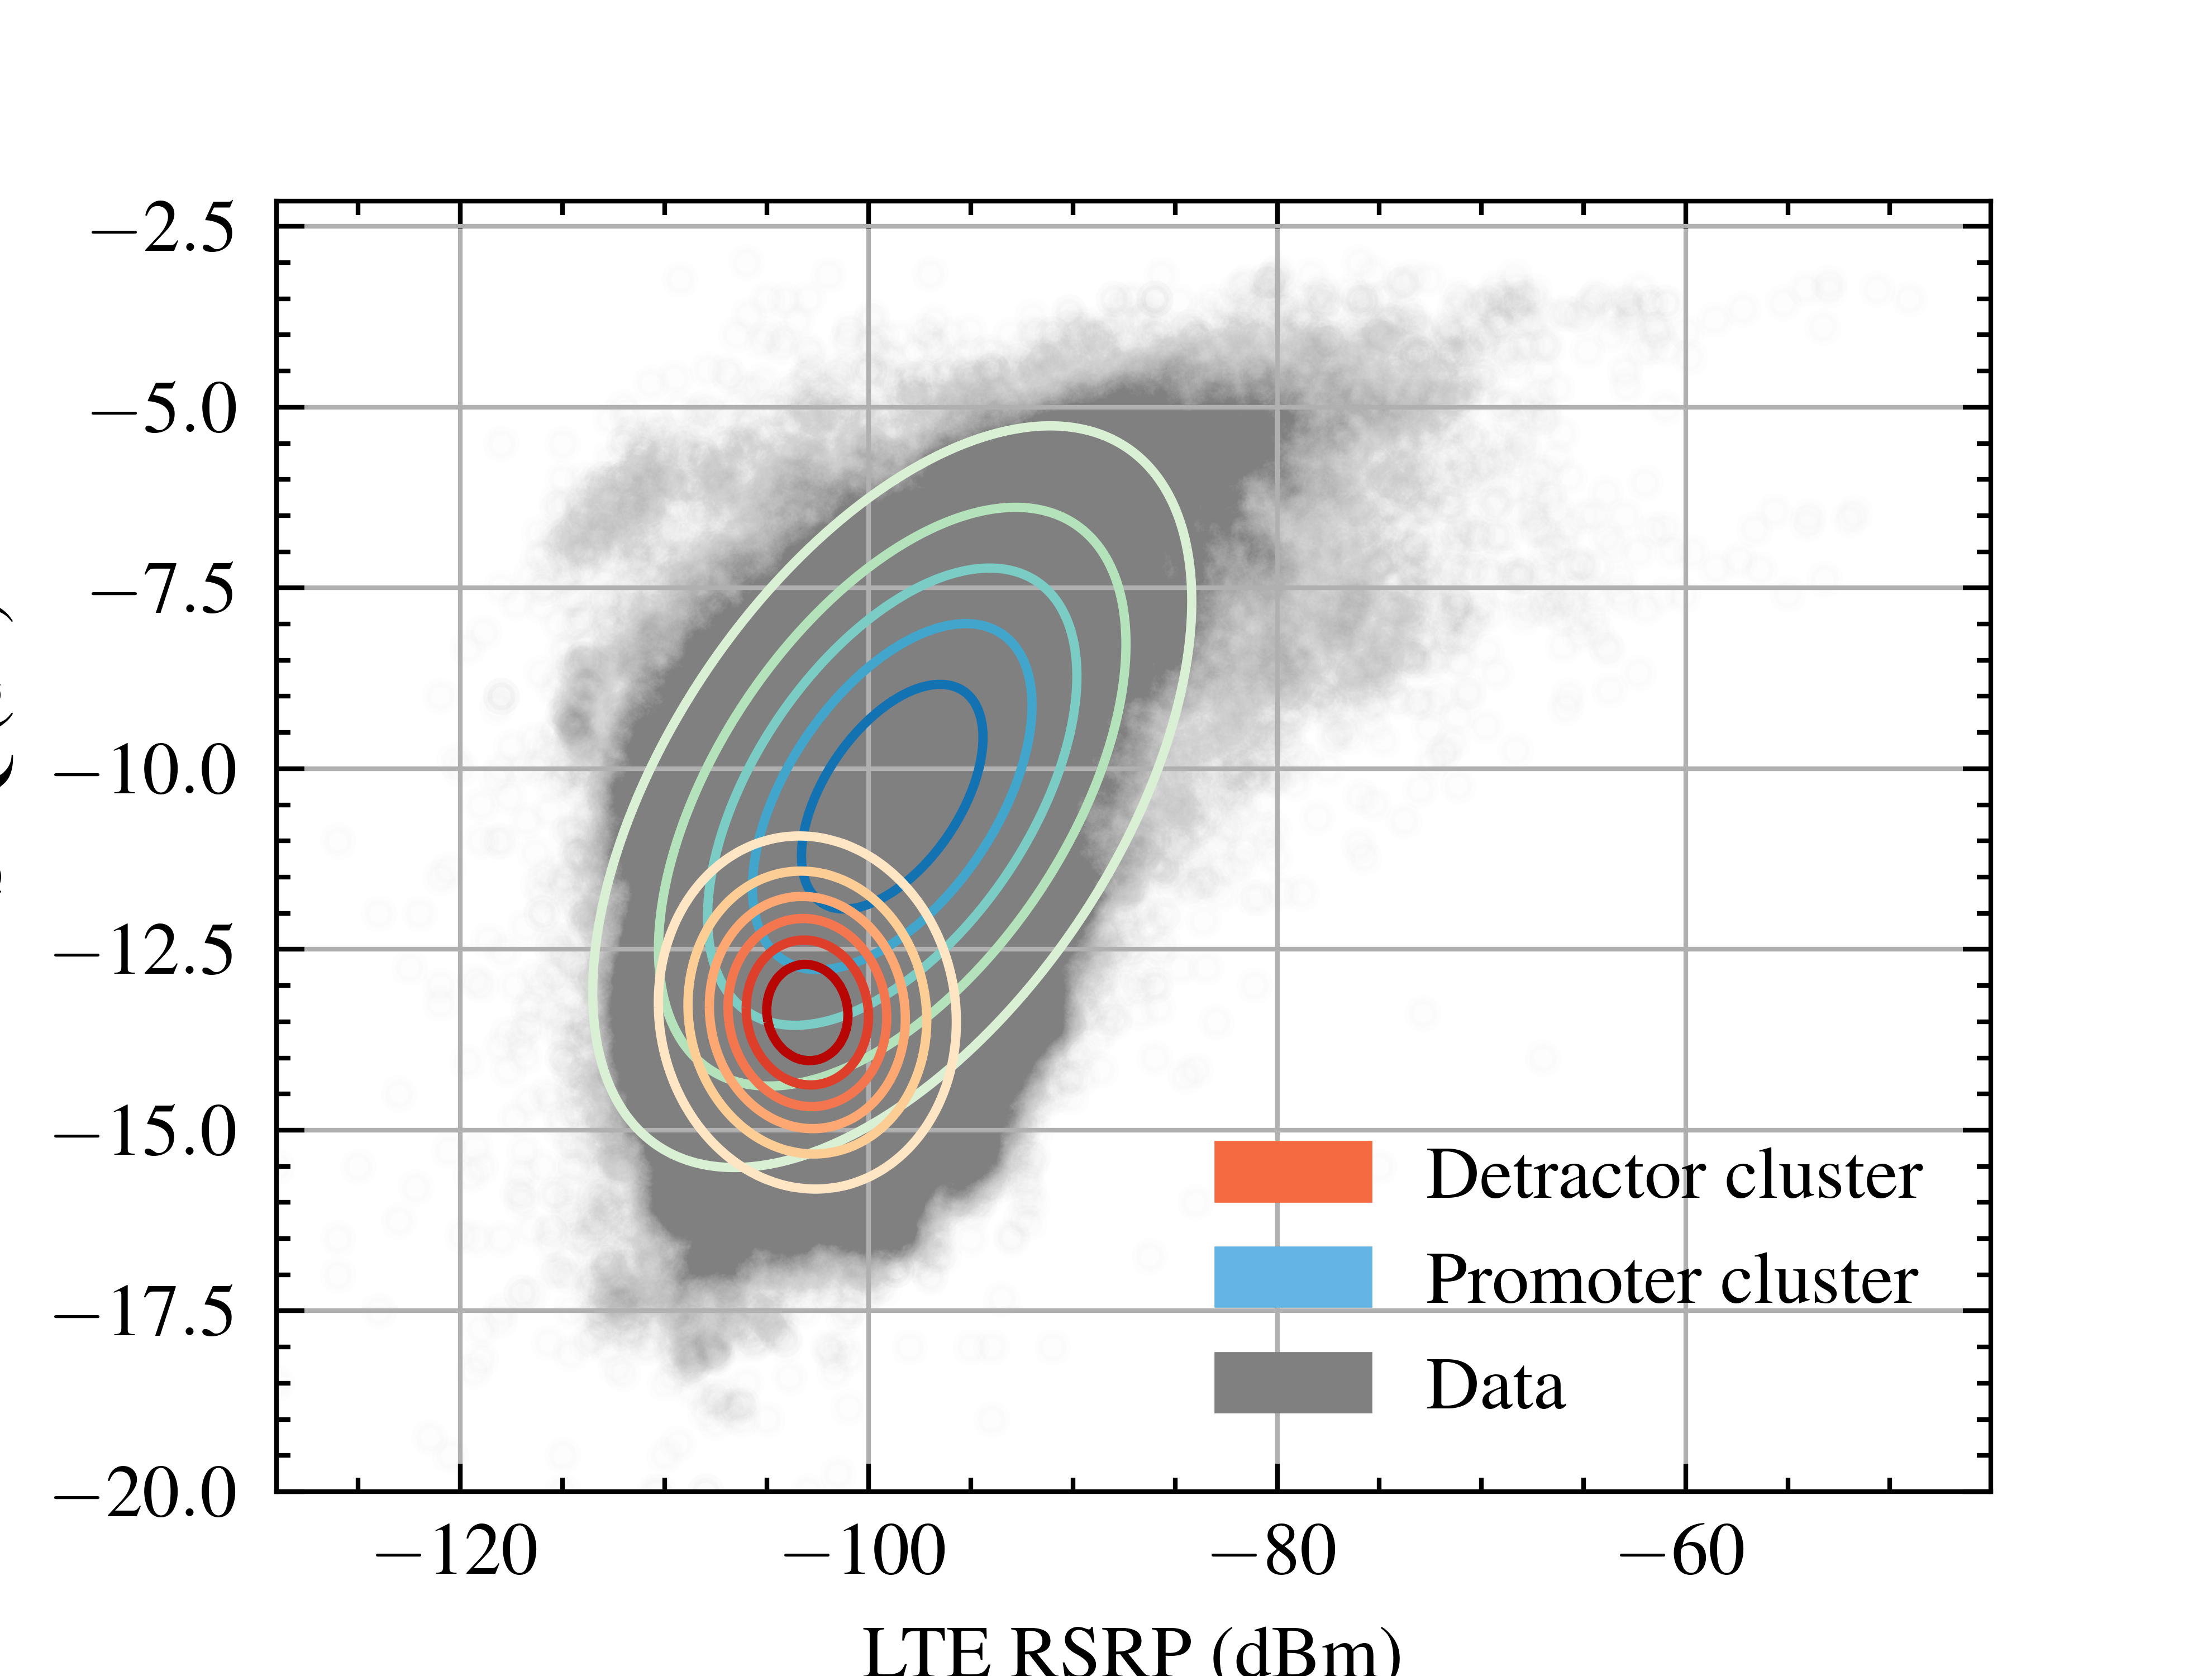

In [ ]:
df_kpi_data = df_kpi_data[~(df_kpi_data == 100000).any(1)]

fig = plt.figure()
ax = fig.add_subplot(111)
x0_min = df_kpi_data['avg_SIGNAL_POWER_dBm_3g'].min()
x0_max = df_kpi_data['avg_SIGNAL_POWER_dBm_3g'].max()
x1_min = df_kpi_data['avg_SIGNAL_QUALITY_dB_3g'].min()
x1_max = df_kpi_data['avg_SIGNAL_QUALITY_dB_3g'].max()

x, y = np.mgrid[x0_min:x0_max:0.1, x1_min:x1_max:0.1]

pos = np.dstack((x, y))

ax.scatter(df_kpi_data['avg_SIGNAL_POWER_dBm_3g'],
           df_kpi_data['avg_SIGNAL_QUALITY_dB_3g'],
           marker='.',
           label='KPI data',
           color='gray',
           alpha=0.01)

for index, row in df_gmm_results.iterrows():
    mean = np.array([row['mean0'], row['mean1']])
    prec = np.array([[row['var0'], row['var1']], 
                     [row['var2'], row['var3']]])
    rv = multivariate_normal(mean, prec)
    if index == 0:
        ax.contour(x, y, rv.pdf(pos), cmap='GnBu')
    else:
        ax.contour(x, y, rv.pdf(pos), cmap='OrRd')
plt.grid()

red_patch = mpatches.Patch(color='#f56a40', label='Detractor cluster')
blue_patch = mpatches.Patch(color='#65b4e6', label='Promoter cluster')
gray_patch = mpatches.Patch(color='gray', label='Data')
plt.legend(handles=[red_patch, blue_patch, gray_patch])

# plt.title("Gaussian mixture distributions")
plt.xlabel("LTE RSRP (dBm)")
plt.ylabel("LTE RSRQ (dB)")
# plt.xlabel('UMTS RSCP (dBm)')
# plt.ylabel('UMTS EC/IO (dB)')
plt.savefig('clusters-LTE.pdf')
plt.savefig('clusters-LTE.png')
plt.show()  